# Andrew Yang's Freedom Dividend

Estimate the effect of Andrew Yang's [Freedom Dividend](https://www.yang2020.com/policies/the-freedom-dividend/) of $12,000 per year per adult over age 18, funded by a 10 percent [value-added tax](https://www.yang2020.com/policies/value-added-tax/) and reducing benefits by up to the UBI amount for each tax unit.

Assumptions:
* Adults are 18+ not 19+, for data availability.
* Benefits include SNAP, WIC, SSI, TANF, WIC, Social Security, and unemployment insurance. Per Yang's [tweet](https://twitter.com/AndrewYang/status/970104619832659968), it excludes housing benefits and Medicare. It also excludes Medicaid, veteran's benefits (which are largely pension and healthcare) and "other benefits" included in C-TAM, which also include some healthcare.
* VAT incidence is proportional to [Tax Policy Center's estimate](https://www.taxpolicycenter.org/briefing-book/who-would-bear-burden-vat) of a 5 percent VAT's effect as of 2015. These are scaled linearly to match Yang's estimate that his VAT would raise $800 billion per year.
* VAT incidence is treated as an income tax; per TPC:
>Conceptually, the tax can either raise the total price (inclusive of the sales tax) paid by consumers or reduce the amount of business revenue available to compensate workers and investors. Theory and evidence suggest that the VAT is passed along to consumers via higher prices. Either way, the decline in real household income is the same regardless of whether prices rise (holding nominal incomes constant) or whether nominal incomes fall (holding the price level constant).

*Data: CPS  |  Tax year: 2019  |  Type: Static  |  Author: Max Ghenis*

## Setup

### Imports

In [1]:
import taxcalc as tc
import taxcalc_helpers as tch
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
tc.__version__

'2.0.0'

### Settings

In [3]:
sns.set_style('white')
DPI = 200
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi'] = DPI
mpl.rcParams['figure.figsize'] = 6.4, 4.8  # Default.

In [4]:
mpl.rcParams['font.sans-serif'] = 'Roboto'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

GRID_COLOR = '#f5f5f5'

# Use Seaborn's default color palette.
# https://stackoverflow.com/q/48958426/1840471 for reproducibility.
sns.set_palette(sns.color_palette())

In [5]:
# Show one decimal in tables.
pd.set_option('precision', 2)

## Major parameters

In [6]:
UBI = 1000 * 12
TOTAL_VAT = 800e9

## Data

In [7]:
recs = tc.Records.cps_constructor()

In [8]:
BENS = ['snap_ben', 'ssi_ben', 'tanf_ben', 'wic_ben',
        'e02400',  # Social Security (OASDI).
        'e02300'  # Unemployment insurance.
       ]

In [9]:
base = tch.calc_df(records=recs, year=2021,  # Yang's page says it begins in 2021.
                   group_vars=['nu18', 'n1820', 'n21'] + BENS,
                   group_n65=True,
                   metric_vars=['aftertax_income', 'XTOT'])
tch.add_weighted_quantiles(base, 'aftertax_income')

### Calculations

In [10]:
base['bens'] = base[BENS].sum(axis=1)
base['adults'] = base.n1820 + base.n21
base['ubi_max'] = base.adults * UBI
# Tax units take the UBI if it exceeds benefits.
base['ubi'] = np.where(base.ubi_max > base.bens, base.ubi_max, 0)
# Tax units that take the UBI decline benefits.
base['bens_yang'] = np.where(base.ubi > 0, 0, base.bens)
base['bens_cut'] = base.bens - base.bens_yang

Weight.

In [11]:
base['ubi_m'] = base.ubi * base.s006 / 1e6
base['ubi_max_m'] = base.ubi_max * base.s006 / 1e6
base['bens_m'] = base.bens * base.s006 / 1e6
base['bens_yang_m'] = base.bens_yang * base.s006 / 1e6
base['bens_cut_m'] = base.bens_cut * base.s006 / 1e6

### Budget breakdown

In [12]:
# In trillions.
budget_t = pd.Series(
    [base.ubi_max_m.sum(),
     base.ubi_m.sum(),
     base.ubi_m.sum() - base.bens_cut_m.sum(),
     base.ubi_m.sum() - base.bens_cut_m.sum() - TOTAL_VAT / 1e6],
    index = ['Total', 'Excluding\nUBI decliners',
             'Less benefit\nsavings', 'Less VAT']) / 1e6

In [13]:
budget_t

Total                       3.05
Excluding\nUBI decliners    2.39
Less benefit\nsavings       2.08
Less VAT                    1.28
dtype: float64

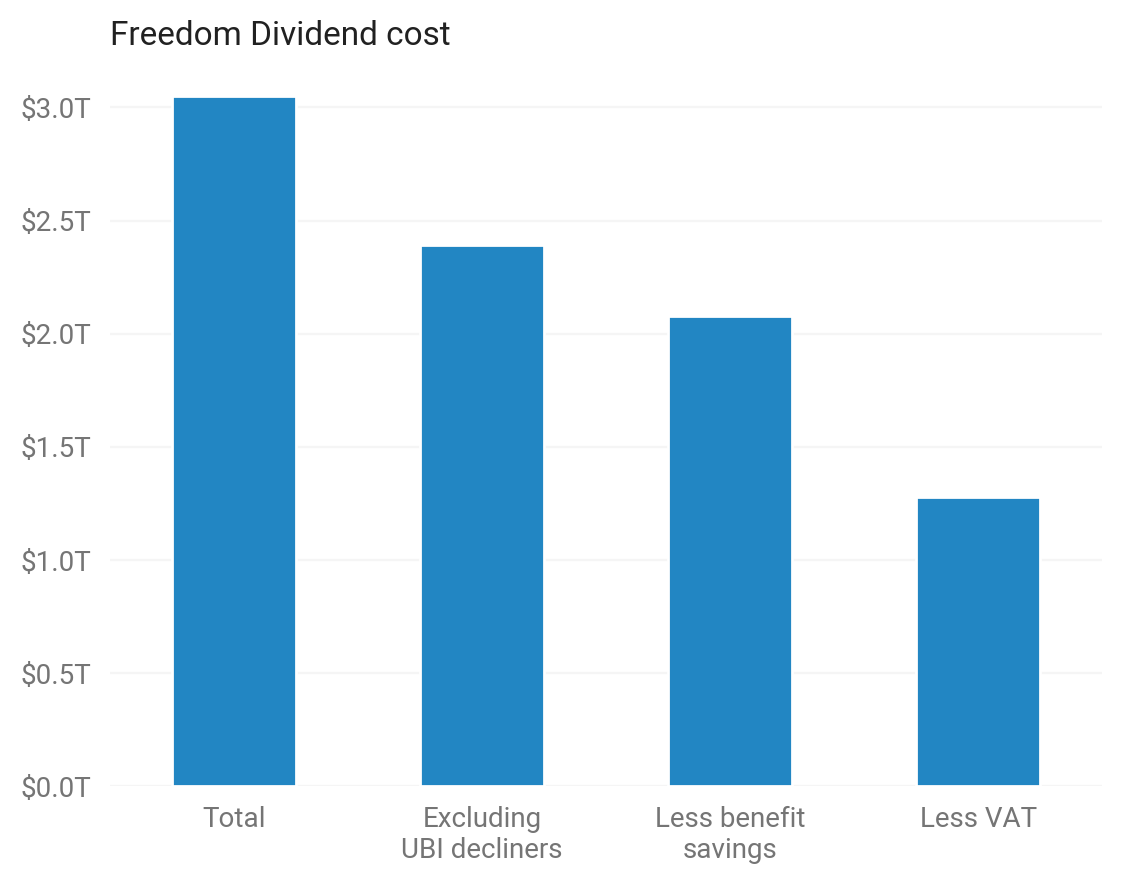

In [14]:
ax = budget_t.plot.bar(color='#2286c3')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda x, _: '$' + format(x, ',') + 'T'))
plt.title('Freedom Dividend cost', loc='left')
ax.grid(color=GRID_COLOR, axis='y')
plt.ylabel('')
plt.xlabel('')
sns.despine(left=True, bottom=True)
plt.xticks(rotation=0)
plt.show()

In [15]:
oasdis = base[(base.e02400 > 0) & (base.adults > 0)]
oasdis['e02400_pp'] = oasdis.e02400 / oasdis.adults

/home/maxghenis/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
oasdis.e02400_pp.describe()

count    127361.00
mean      15863.57
std        7758.68
min           0.58
25%       10236.05
50%       15774.99
75%       20534.40
max       63382.88
Name: e02400_pp, dtype: float64

In [17]:
base[(base.ubi + base.e02400 == 0)].sample()[['XTOT', 'adults', 'ubi_max', 'ubi', 'bens', 'bens_yang'] + BENS]

,XTOT,adults,ubi_max,ubi,bens,bens_yang,snap_ben,ssi_ben,tanf_ben,wic_ben,e02400,e02300
RECID,,,,,,,,,,,,
299493,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
base[base.ubi == 0].sample()[['XTOT', 'adults', 'ubi_max', 'ubi', 'bens', 'bens_yang'] + BENS]

,XTOT,adults,ubi_max,ubi,bens,bens_yang,snap_ben,ssi_ben,tanf_ben,wic_ben,e02400,e02300
RECID,,,,,,,,,,,,
125781,1.0,1.0,12000.0,0.0,19512.03,19512.03,3666.88,0.0,0.0,0.0,15845.15,0.0


### VAT

Start with equal incidence, then re-weight according to [TPC paper](https://www.taxpolicycenter.org/briefing-book/who-would-bear-burden-vat).

In [19]:
VAT_INCIDENCE = pd.DataFrame({
    'income_percentile_floor': [-1, 20, 40, 60, 80, 90, 95, 99, 99.9],
    'rate': [3.9, 3.6, 3.6, 3.6, 3.4, 3.2, 2.8, 2.5, 2.5]
})
VAT_INCIDENCE.rate /= 100

In [20]:
base['afti_yang_prevat'] = base.aftertax_income + base.ubi - base.bens_cut
base['afti_yang_prevat_noneg'] = base.afti_yang_prevat.clip_lower(0)

In [21]:
base.afti_yang_prevat.median() - base.aftertax_income.median()

14821.574947219488

In [22]:
tch.add_weighted_quantiles(base, 'afti_yang_prevat_noneg')

In [23]:
base['vat_rate_prescale'] = VAT_INCIDENCE.rate[
    pd.cut(base.afti_yang_prevat_noneg_percentile_exact,
           bins=VAT_INCIDENCE.income_percentile_floor.tolist() + [100],
           labels=False)].values

In [24]:
base['vat_base'] = base.afti_yang_prevat_noneg * base.vat_rate_prescale

In [25]:
vat_mult = TOTAL_VAT / tch.weighted_sum(base, 'vat_base')
vat_mult

1.5132474496382293

In [26]:
2.3e12 / tch.weighted_sum(base, 'vat_base')

4.350586417709909

In [27]:
base['vat'] = base.vat_base * vat_mult
base['vat_m'] = tch.weight(base, 'vat') / 1e6
base['afti_yang_prevat_noneg_m'] = tch.weight(base, 'afti_yang_prevat_noneg') / 1e6

In [28]:
base['afti_yang'] = base.afti_yang_prevat - base.vat

In [29]:
tch.gini(base.aftertax_income, base.s006)

0.45298531461211183

In [30]:
tch.gini(base.afti_yang, base.s006)

0.4103047357388543

In [31]:
base.afti_yang.describe()

count    4.56e+05
mean     1.57e+05
std      1.73e+06
min     -3.64e+06
25%      5.22e+04
50%      9.98e+04
75%      1.85e+05
max      1.15e+09
Name: afti_yang, dtype: float64

In [32]:
base['afti_chg'] = base.afti_yang - base.aftertax_income
base['afti_chg_m'] = base.afti_chg * base.s006 / 1e6

In [33]:
'${} trillion shortfall'.format((base.afti_chg_m.sum() / 1e6).round(2))

'$1.28 trillion shortfall'

In [34]:
base[(base.afti_chg < 0) & (base.bens > 0)].sample()[['bens', 'bens_yang', 'ubi', 'aftertax_income', 'afti_yang', 'vat', 'afti_chg']]

,bens,bens_yang,ubi,aftertax_income,afti_yang,vat,afti_chg
RECID,,,,,,,
390023,34985.13,34985.13,0.0,117849.39,111429.32,6420.07,-6420.07


## Analysis

### Benefit reductions

Exploratory.

In [35]:
base.columns

Index(['nu18', 'ssi_ben', 'n1820', 'e02300', 'e02400', 'snap_ben', 's006',
       'aftertax_income', 'n21', 'tanf_ben', 'wic_ben', 'XTOT', 'n65',
       's006_m', 'aftertax_income_m', 'XTOT_m',
       'aftertax_income_percentile_exact', 'aftertax_income_percentile',
       'aftertax_income_2percentile', 'aftertax_income_ventile',
       'aftertax_income_decile', 'aftertax_income_quintile',
       'aftertax_income_quartile', 'bens', 'adults', 'ubi_max', 'ubi',
       'bens_yang', 'bens_cut', 'ubi_m', 'ubi_max_m', 'bens_m', 'bens_yang_m',
       'bens_cut_m', 'afti_yang_prevat', 'afti_yang_prevat_noneg',
       'afti_yang_prevat_noneg_percentile_exact',
       'afti_yang_prevat_noneg_percentile',
       'afti_yang_prevat_noneg_2percentile', 'afti_yang_prevat_noneg_ventile',
       'afti_yang_prevat_noneg_decile', 'afti_yang_prevat_noneg_quintile',
       'afti_yang_prevat_noneg_quartile', 'vat_rate_prescale', 'vat_base',
       'vat', 'vat_m', 'afti_yang_prevat_noneg_m', 'afti_yang', 'af

In [36]:
base[base.e02400 > 0].sample()[['ubi', 'e02400', 'bens_yang', 'adults']]

,ubi,e02400,bens_yang,adults
RECID,,,,
347244,0.0,28450.65,28450.65,2.0


In [37]:
BEN_NAME = {
    'e02400': 'Social Security',
    'e02300': 'Unemployment',
    'snap_ben': 'SNAP',
    'ssi_ben': 'SSI',
    'tanf_ben': 'TANF',
    'housing_ben': 'Housing assistance',
    'wic_ben': 'WIC',
    'other_ben': 'Other'
}

In [38]:
ben_reduction_l = []
for i in BENS:
    tmp = pd.DataFrame({
        'base': [tch.weighted_sum(base, i)],
        'yang': [tch.weighted_sum(base[base.ubi == 0], i)]
    }, index=[i])
    ben_reduction_l.append(tmp)

ben_reduction = pd.concat(ben_reduction_l)
ben_reduction['ben_name'] = ben_reduction.index.map(BEN_NAME)
ben_reduction['reduction'] = ben_reduction.base - ben_reduction.yang
ben_reduction['pct_reduction'] = ben_reduction.reduction / ben_reduction.base
ben_reduction

,base,yang,ben_name,reduction,pct_reduction
snap_ben,9.07e+10,3.35e+10,SNAP,5.72e+10,0.63
ssi_ben,5.53e+10,3.55e+10,SSI,1.99e+10,0.36
tanf_ben,3.05e+10,1.76e+10,TANF,1.30e+10,0.42
wic_ben,3.79e+09,4.05e+08,WIC,3.38e+09,0.89
e02400,1.20e+12,1.01e+12,Social Security,1.97e+11,0.16
e02300,3.04e+10,4.97e+09,Unemployment,2.54e+10,0.84


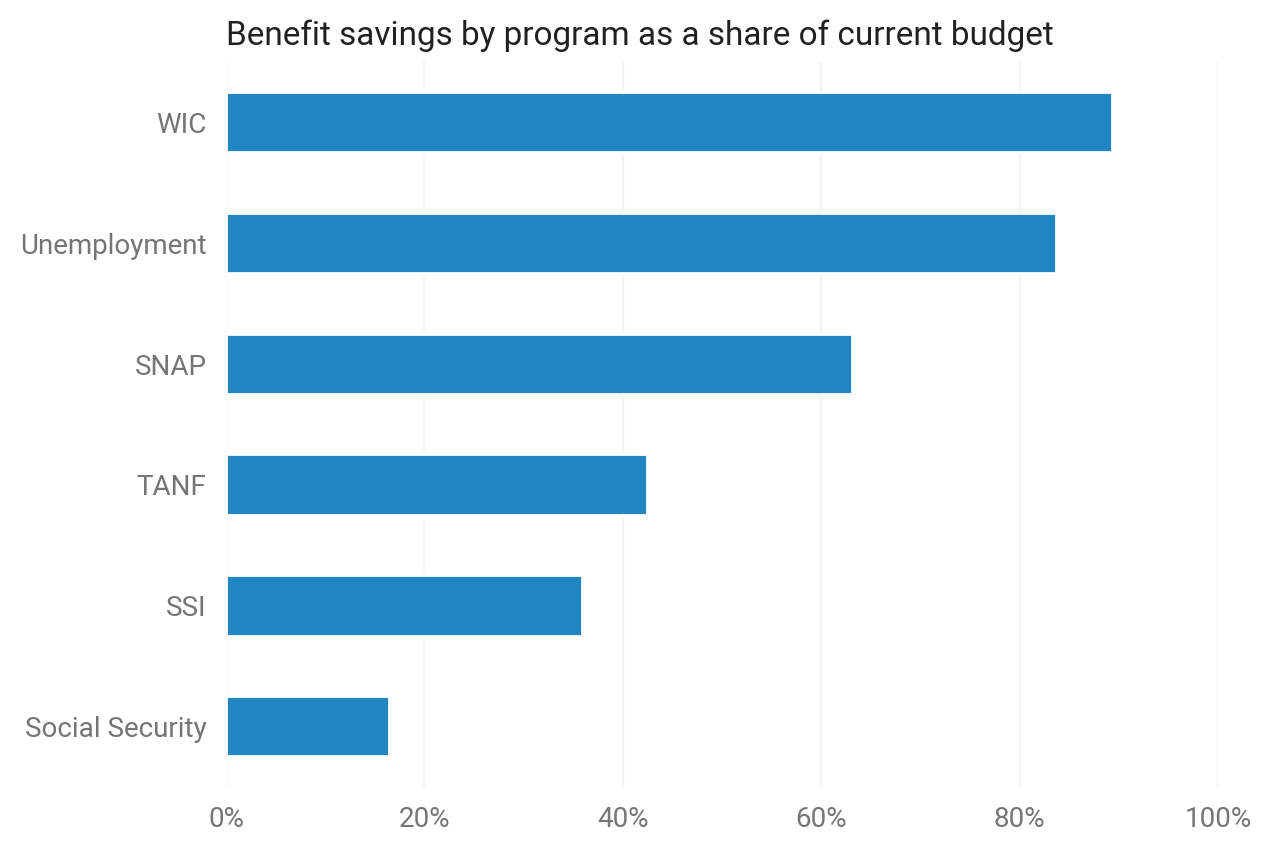

In [39]:
ax = ben_reduction.sort_values('pct_reduction').plot.barh(x='ben_name', y='pct_reduction', color='#2286c3')
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda x, _: '{:.0%}'.format(x)))
plt.title('Benefit savings by program as a share of current budget', loc='left')
ax.grid(color=GRID_COLOR, axis='x')
ax.legend_.remove()
plt.ylabel('')
sns.despine(left=True, bottom=True)
plt.show()

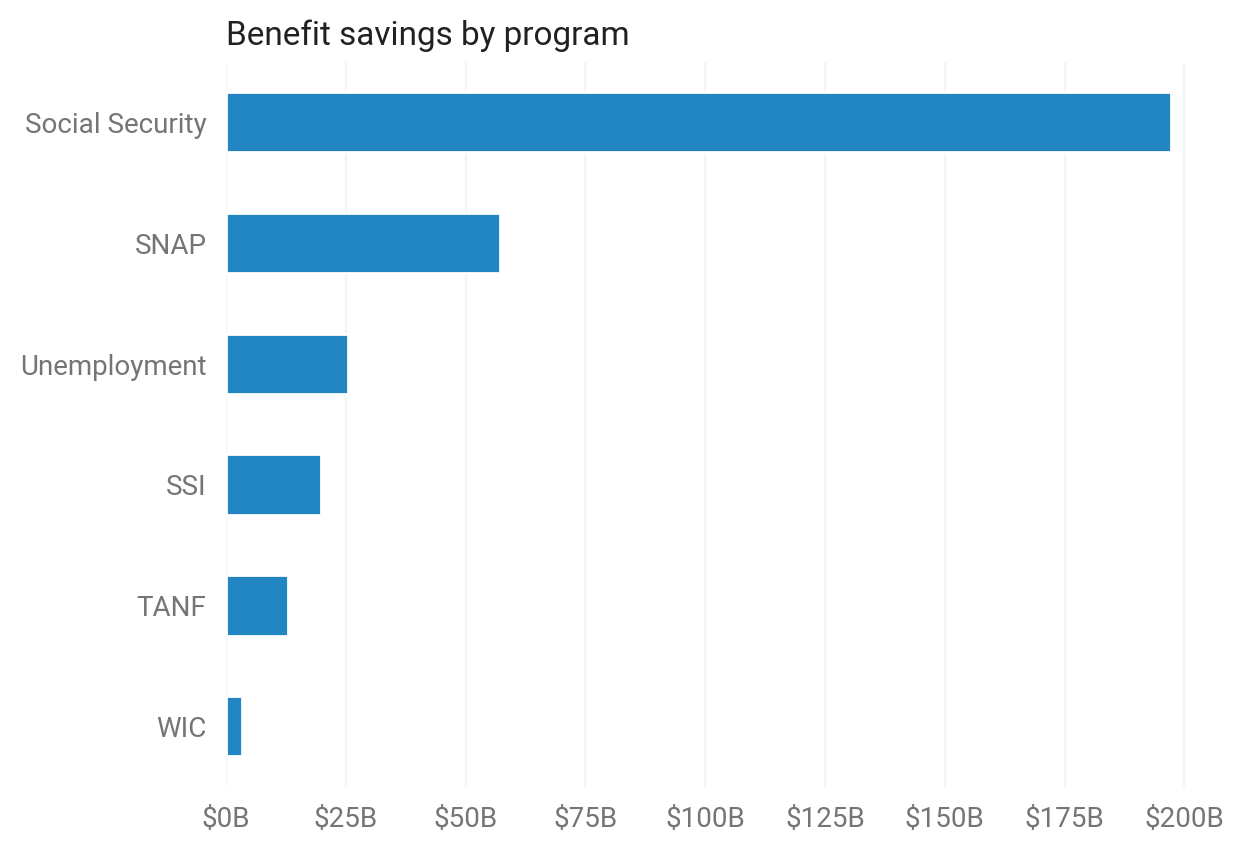

In [40]:
ax = ben_reduction.sort_values('reduction').plot.barh(x='ben_name', y='reduction', color='#2286c3')
# plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda x, _: '$' + format(int(x / 1e9), ',') + 'B'))
plt.title('Benefit savings by program', loc='left')
ax.grid(color=GRID_COLOR, axis='x')
ax.legend_.remove()
plt.ylabel('')
sns.despine(left=True, bottom=True)
plt.show()

In [41]:
base.sort_values('afti_chg', ascending=False).head()

,nu18,ssi_ben,n1820,e02300,e02400,snap_ben,s006,aftertax_income,n21,tanf_ben,...,afti_yang_prevat_noneg_quintile,afti_yang_prevat_noneg_quartile,vat_rate_prescale,vat_base,vat,vat_m,afti_yang_prevat_noneg_m,afti_yang,afti_chg,afti_chg_m
RECID,,,,,,,,,,,,,,,,,,,,,
167613,0.0,0.0,1.0,0.00,0.00,0.0,898.14,3138.33,11.0,0.0,...,5,4,0.03,5002.70,7570.33,6.80,132.15,139568.00,136429.67,122.53
21452,0.0,0.0,1.0,2492.51,1708.95,0.0,1205.70,120214.91,7.0,0.0,...,5,4,0.03,6784.43,10266.52,12.38,255.62,201746.93,81532.02,98.30
388397,0.0,0.0,1.0,0.00,0.00,0.0,564.04,0.00,6.0,0.0,...,4,3,0.04,3024.00,4576.06,2.58,47.38,79423.94,79423.94,44.80
143105,1.0,0.0,3.0,0.00,0.00,0.0,910.68,34182.48,4.0,0.0,...,4,4,0.04,4254.57,6438.22,5.86,107.63,111744.26,77561.78,70.63
201252,0.0,0.0,0.0,693.49,0.00,0.0,109.72,24067.54,7.0,0.0,...,4,3,0.04,3865.47,5849.41,0.64,11.78,101524.64,77457.11,8.50


In [42]:
base.vat_m.sum() / base.afti_yang_prevat_noneg_m.sum()

0.05076428651685307

In [43]:
decile = base.groupby('aftertax_income_decile')['aftertax_income_m', 'afti_chg_m',
                                                'vat_m', 'afti_yang_prevat_noneg_m', 's006'].sum()
decile['afti_chg'] = 1e6 * decile.afti_chg_m / decile.s006
decile['afti_chg_pct'] = decile.afti_chg_m / decile.aftertax_income_m
decile['vat'] = 1e6 * decile.vat_m / decile.s006
decile['vat_pct'] = decile.vat_m / decile.afti_yang_prevat_noneg_m
decile.drop(0, inplace=True)
decile

,aftertax_income_m,afti_chg_m,vat_m,afti_yang_prevat_noneg_m,s006,afti_chg,afti_chg_pct,vat,vat_pct
aftertax_income_decile,,,,,,,,,
1,1.82e+05,174561.55,22235.45,3.79e+05,1.69e+07,10315.40,0.96,1313.96,0.06
2,4.28e+05,159196.40,35680.36,6.22e+05,1.70e+07,9378.61,0.37,2102.01,0.06
3,5.73e+05,127796.94,41223.97,7.42e+05,1.70e+07,7528.81,0.22,2428.60,0.06
4,7.11e+05,129496.74,48566.14,8.89e+05,1.70e+07,7628.58,0.18,2861.00,0.05
5,8.72e+05,135759.90,58087.67,1.07e+06,1.70e+07,7997.79,0.16,3422.02,0.05
6,1.07e+06,124826.09,69062.12,1.27e+06,1.70e+07,7353.64,0.12,4068.52,0.05
7,1.33e+06,128952.91,83796.60,1.54e+06,1.70e+07,7596.84,0.10,4936.60,0.05
8,1.67e+06,128080.65,102453.38,1.90e+06,1.70e+07,7545.52,0.08,6035.76,0.05
9,2.23e+06,113402.81,127674.81,2.48e+06,1.70e+07,6680.49,0.05,7521.24,0.05


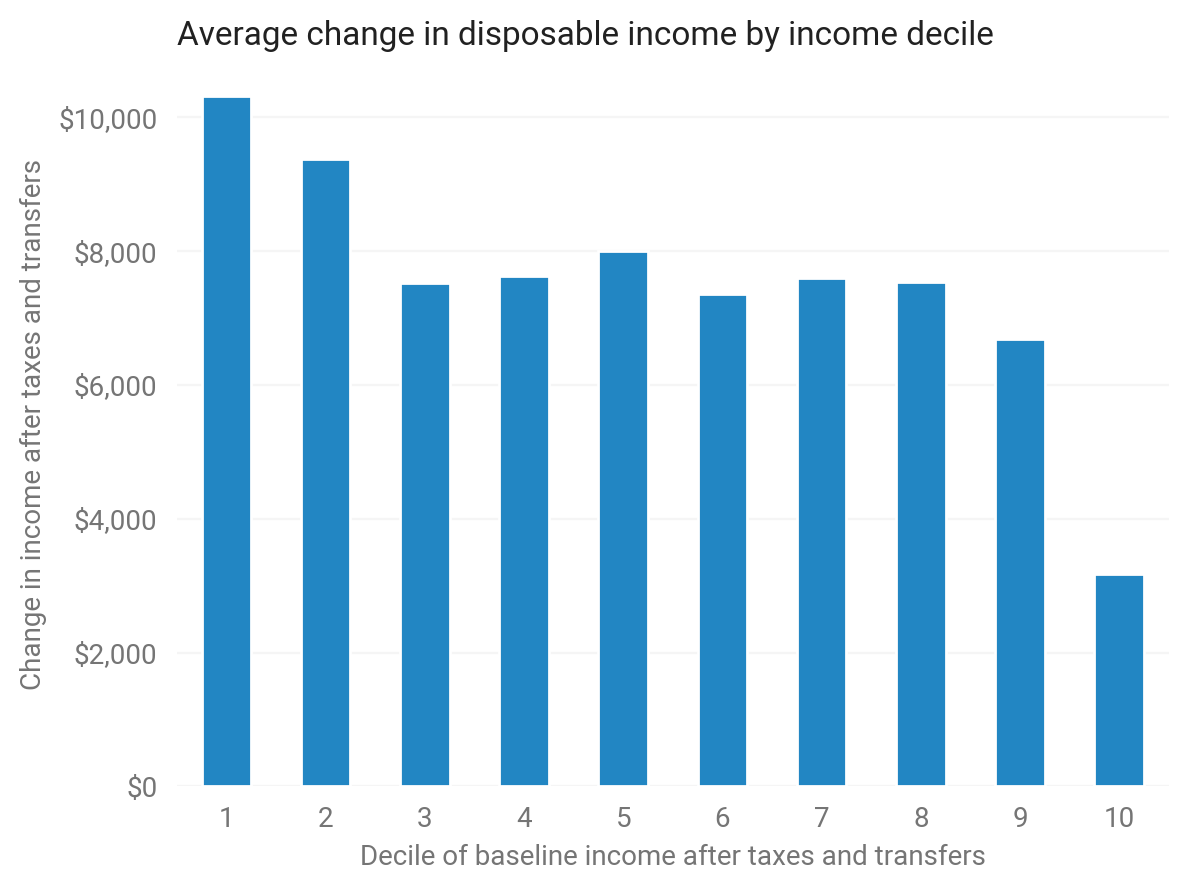

In [44]:
ax = decile.afti_chg.plot.bar(color='#2286c3')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda x, _: '$' + format(int(x), ',')))
plt.title('Average change in disposable income by income decile', loc='left')
ax.grid(color=GRID_COLOR, axis='y')
plt.ylabel('Change in income after taxes and transfers')
plt.xlabel('Decile of baseline income after taxes and transfers')
sns.despine(left=True, bottom=True)
plt.xticks(rotation=0)
plt.show()

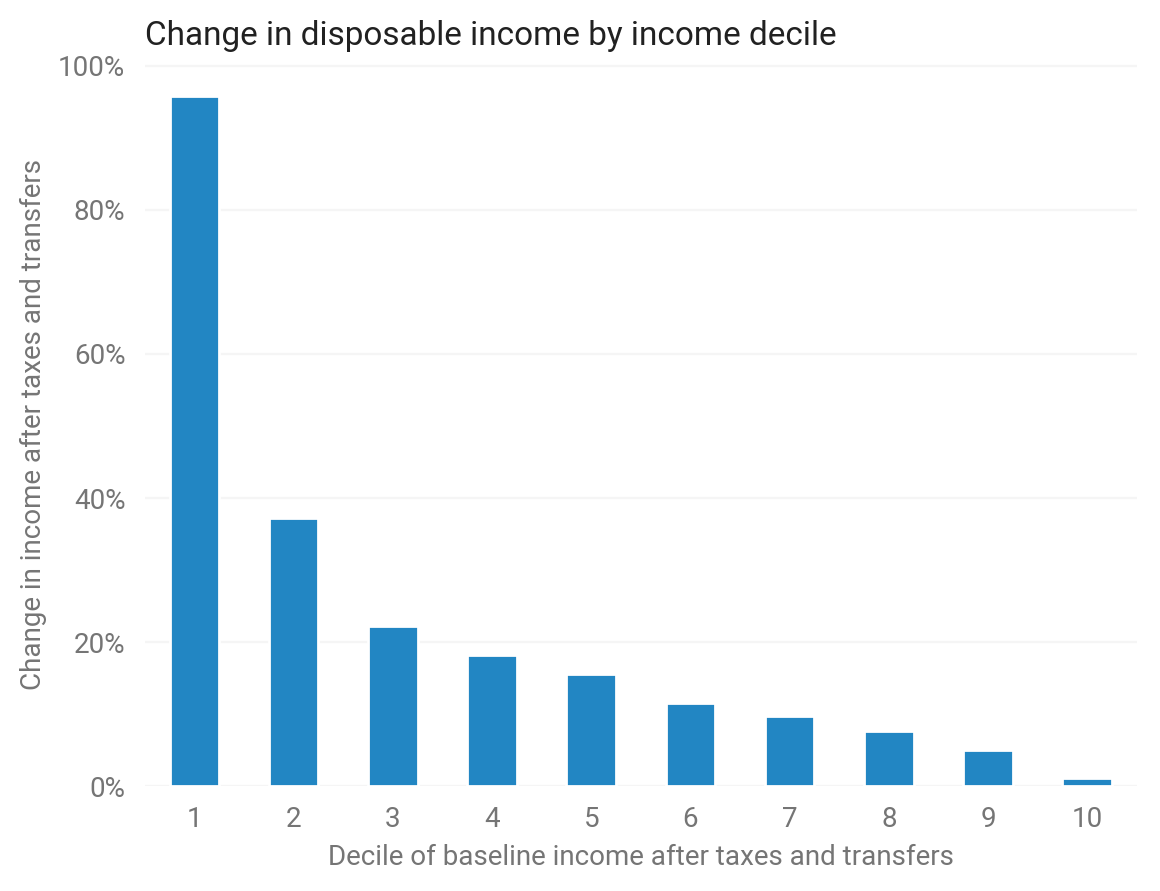

In [45]:
ax = decile.afti_chg_pct.plot.bar(color='#2286c3')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda x, _: '{:.0%}'.format(x)))
plt.xticks(rotation=0)
plt.title('Change in disposable income by income decile', loc='left')
ax.grid(color=GRID_COLOR, axis='y')
plt.ylabel('Change in income after taxes and transfers')
plt.xlabel('Decile of baseline income after taxes and transfers')
sns.despine(left=True, bottom=True)
plt.show()

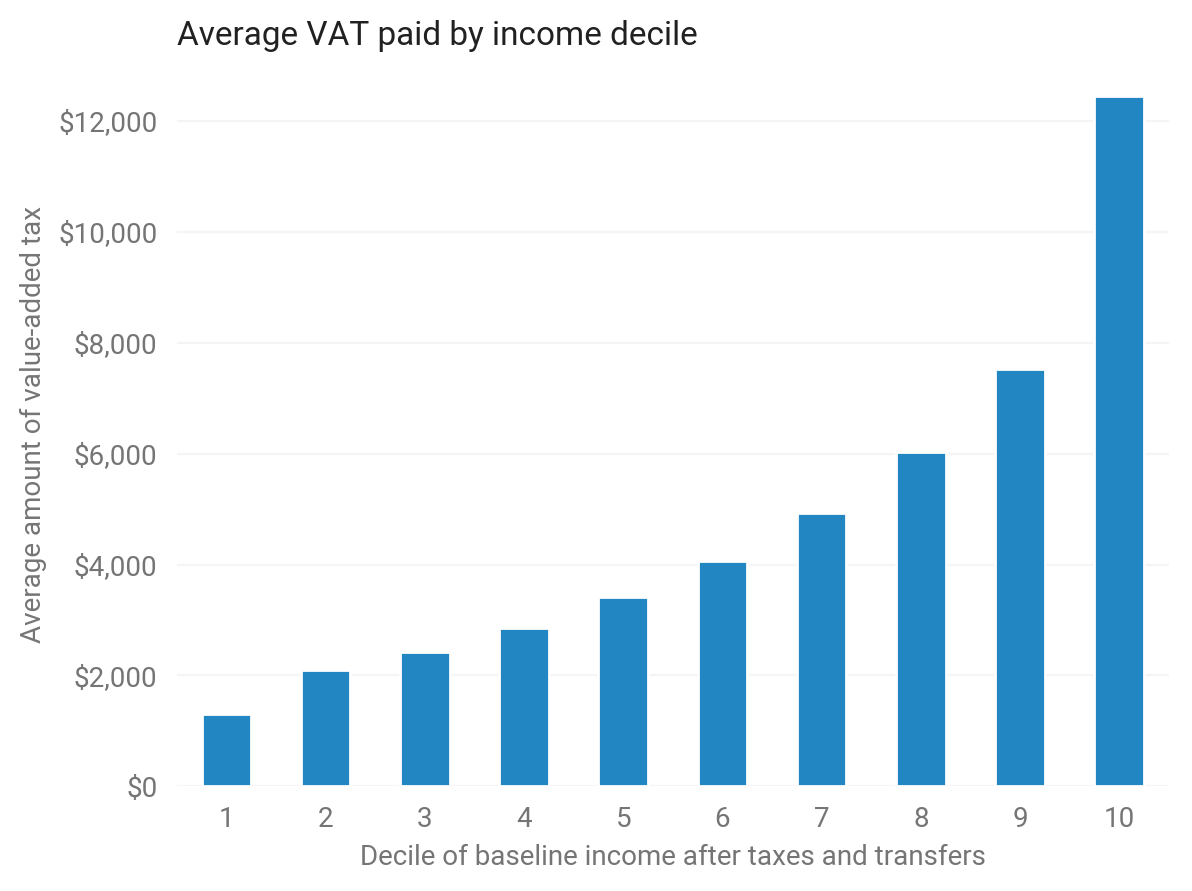

In [46]:
ax = decile.vat.plot.bar(color='#2286c3')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda x, _: '$' + format(int(x), ',')))
plt.title('Average VAT paid by income decile', loc='left')
ax.grid(color=GRID_COLOR, axis='y')
plt.ylabel('Average amount of value-added tax')
plt.xlabel('Decile of baseline income after taxes and transfers')
sns.despine(left=True, bottom=True)
plt.xticks(rotation=0)
plt.show()

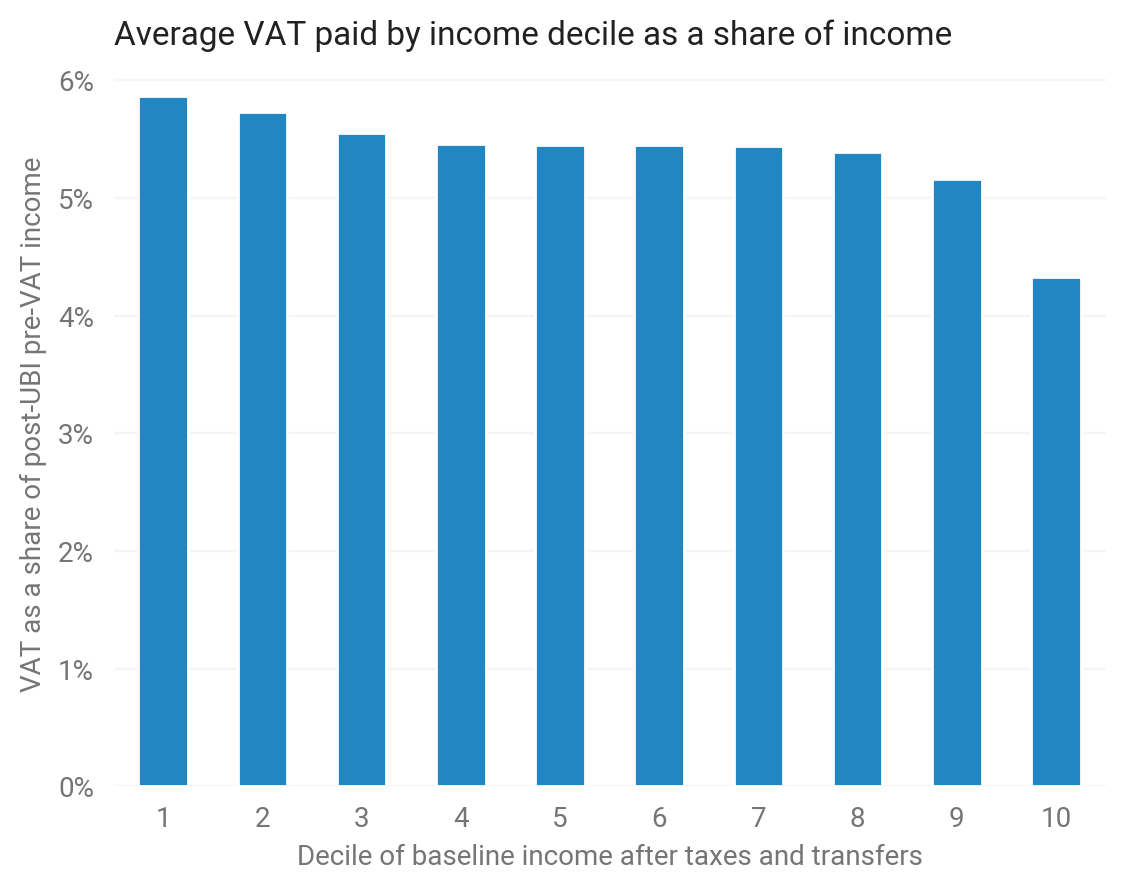

In [47]:
ax = decile.vat_pct.plot.bar(color='#2286c3')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda x, _: '{:.0%}'.format(x)))
plt.title('Average VAT paid by income decile as a share of income', loc='left')
ax.grid(color=GRID_COLOR, axis='y')
plt.ylabel('VAT as a share of post-UBI pre-VAT income')
plt.xlabel('Decile of baseline income after taxes and transfers')
sns.despine(left=True, bottom=True)
plt.xticks(rotation=0)
plt.show()

In [48]:
ventile = base.groupby('aftertax_income_ventile')['aftertax_income_m', 'afti_chg_m', 's006'].sum()
ventile['afti_chg'] = 1e6 * ventile.afti_chg_m / ventile.s006
ventile['afti_chg_pct'] = ventile.afti_chg_m / ventile.aftertax_income_m
ventile.drop(0, inplace=True)
ventile

,aftertax_income_m,afti_chg_m,s006,afti_chg,afti_chg_pct
aftertax_income_ventile,,,,,
5,4.28e+04,88329.87,8.43e+06,10472.03,2.06e+00
10,1.39e+05,86231.68,8.49e+06,10159.74,6.18e-01
15,1.93e+05,84918.14,8.49e+06,10005.82,4.40e-01
20,2.35e+05,74278.25,8.49e+06,8751.45,3.17e-01
25,2.70e+05,66126.32,8.49e+06,7791.05,2.45e-01
30,3.03e+05,61670.62,8.49e+06,7266.56,2.04e-01
35,3.37e+05,63197.52,8.49e+06,7446.06,1.87e-01
40,3.74e+05,66299.22,8.49e+06,7811.08,1.77e-01
45,4.14e+05,69254.68,8.49e+06,8159.61,1.67e-01


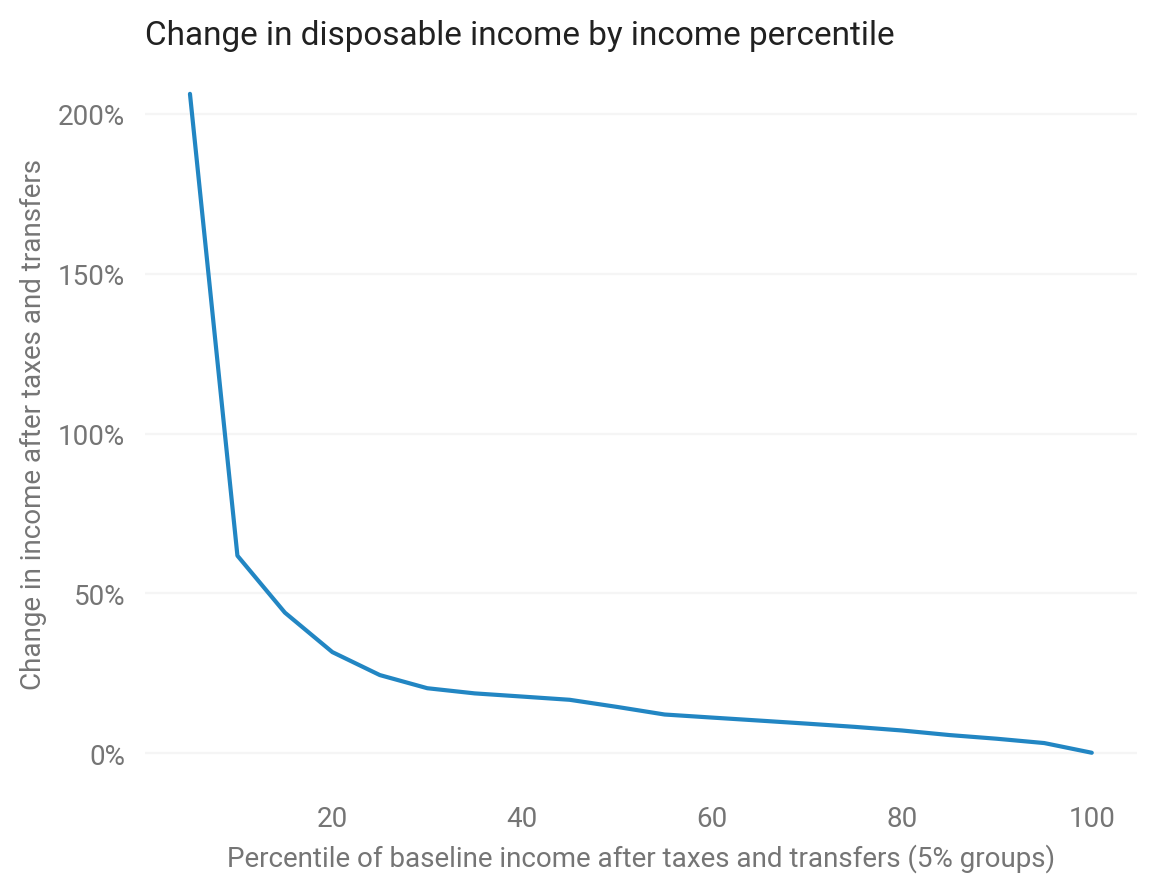

In [49]:
ax = ventile.afti_chg_pct.plot(color='#2286c3')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda x, _: '{:.0%}'.format(x)))
plt.title('Change in disposable income by income percentile', loc='left')
ax.grid(color=GRID_COLOR, axis='y')
plt.xlabel('Percentile of baseline income after taxes and transfers (5% groups)')
plt.ylabel('Change in income after taxes and transfers')
sns.despine(left=True, bottom=True)
plt.show()

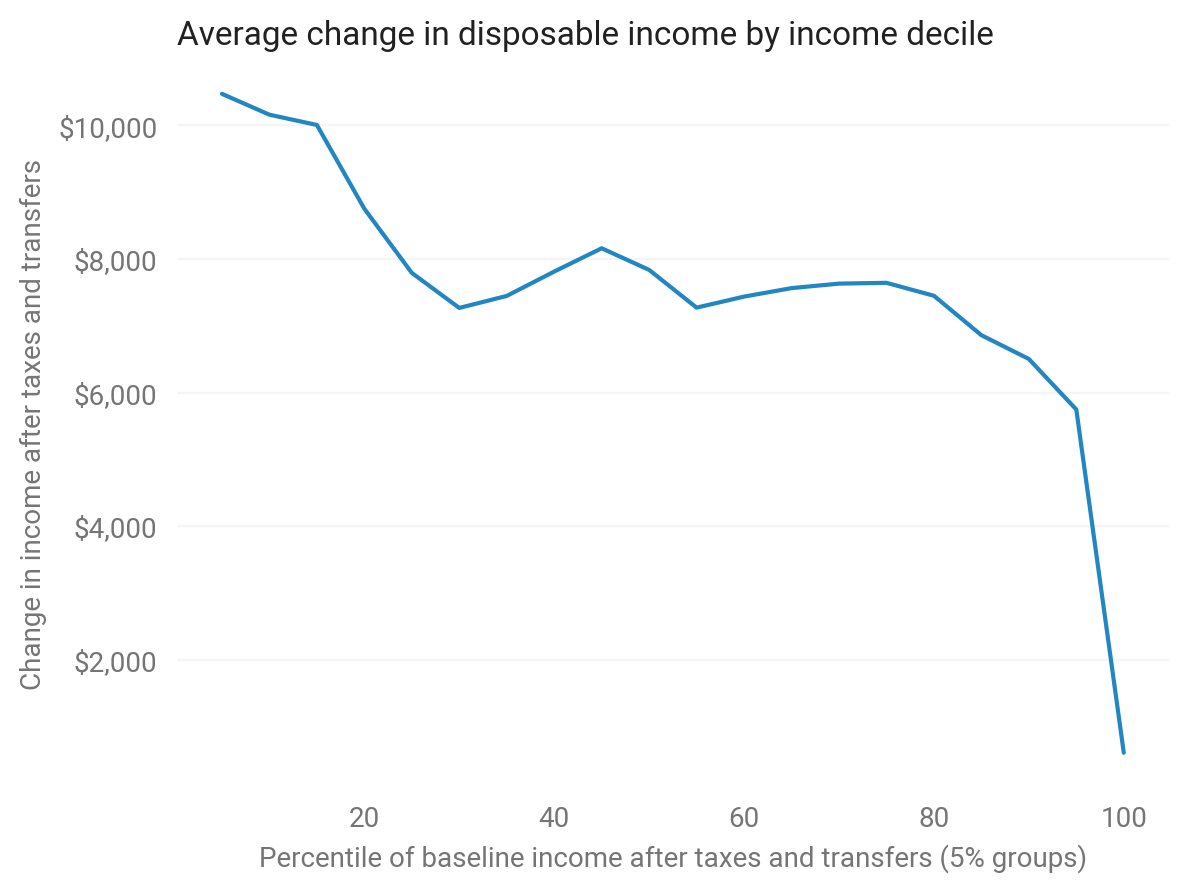

In [50]:
ax = ventile.afti_chg.plot(color='#2286c3')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda x, _: '$' + format(int(x), ',')))
plt.title('Average change in disposable income by income decile', loc='left')
ax.grid(color=GRID_COLOR, axis='y')
plt.xlabel('Percentile of baseline income after taxes and transfers (5% groups)')
plt.ylabel('Change in income after taxes and transfers')
sns.despine(left=True, bottom=True)
plt.show()

### Poverty

In [51]:
base['fpl'] = tch.fpl(base.XTOT)
base['fpl_base_m'] = base.XTOT_m * (base.aftertax_income < base.fpl)
base['fpl_yang_m'] = base.XTOT_m * (base.afti_yang < base.fpl)

In [52]:
base.fpl_base_m.sum() / base.XTOT_m.sum()

0.045067000180069275

In [53]:
base.fpl_yang_m.sum() / base.XTOT_m.sum()

0.01143735409870928

In [54]:
base[base.fpl_base_m < base.fpl_yang_m].adults.describe()

count    92.00
mean      0.36
std       0.50
min       0.00
25%       0.00
50%       0.00
75%       1.00
max       2.00
Name: adults, dtype: float64

### Inequality

In [55]:
tch.gini(base.aftertax_income, base.s006)

0.45298531461211183

In [56]:
tch.gini(base.afti_yang, base.s006)

0.4103047357388543

### Change in deciles

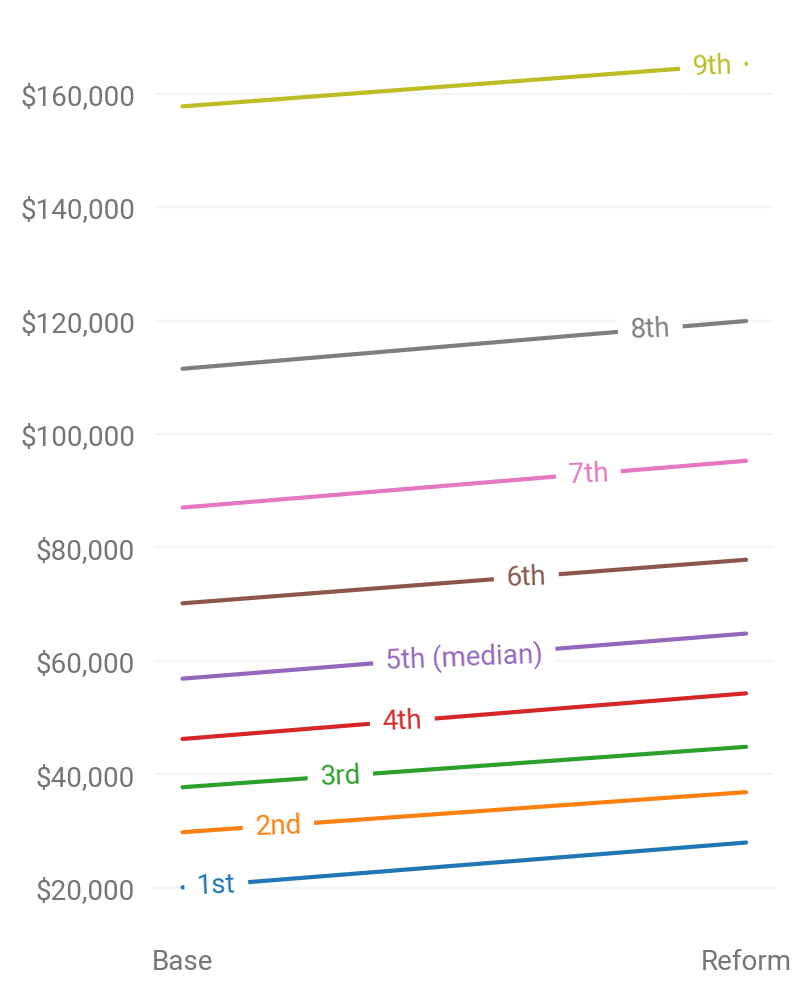

In [57]:
ax = tch.quantile_chg_plot(base.aftertax_income, base.afti_yang, base.s006, base.s006)
ax.grid(color=GRID_COLOR, axis='y')
fmt = mpl.ticker.FuncFormatter(lambda x, _: '$' + format(int(x), ','))
ax.yaxis.set_major_formatter(fmt)
ax.yaxis.set_minor_formatter(fmt)
# ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
#     lambda x, _: '$' + format(int(x), ',')))
plt.gcf().set_size_inches(4, 6)
plt.show()

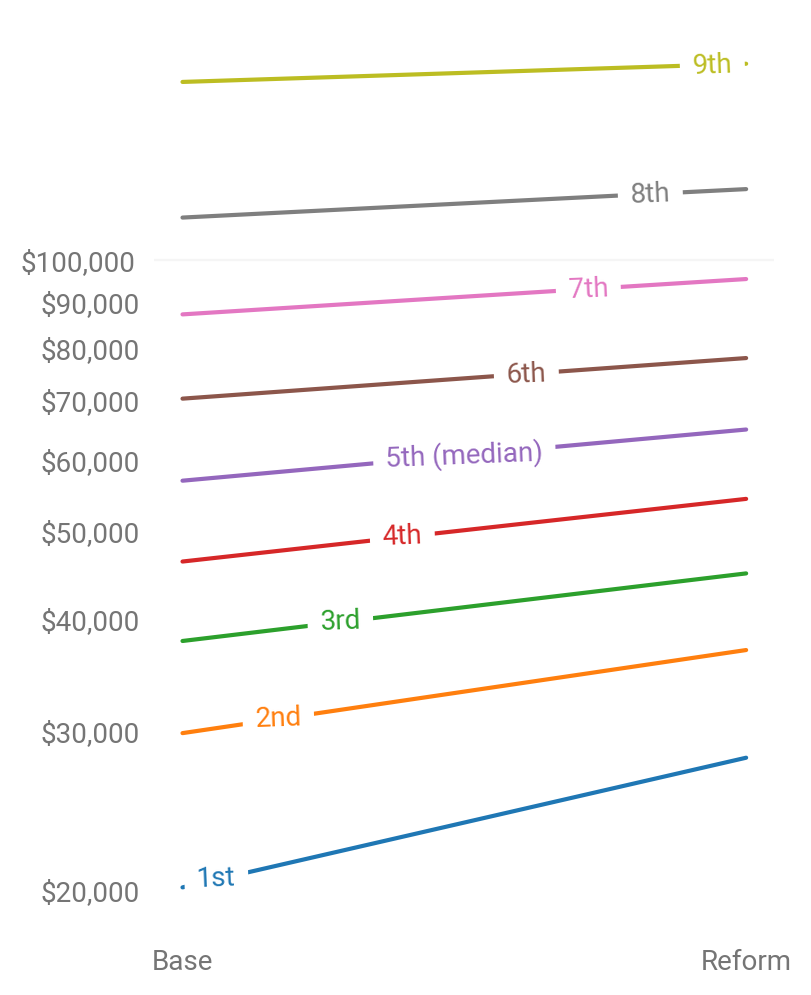

In [58]:
ax = tch.quantile_chg_plot(base.aftertax_income, base.afti_yang, base.s006, base.s006)
ax.grid(color=GRID_COLOR, axis='y')
plt.yscale('log')
# ax.yaxis.get_major_formatter().set_useOffset(False)
fmt = mpl.ticker.FuncFormatter(lambda x, _: '$' + format(int(x), ','))
ax.yaxis.set_major_formatter(fmt)
ax.yaxis.set_minor_formatter(fmt)
plt.gcf().set_size_inches(4, 6)
plt.show()

## Normalize

In [59]:
qchg = tch.quantile_chg(base.aftertax_income, base.afti_yang, base.s006, base.s006).transpose()
qchg.columns = ['base', 'reform']
qchg['pct_chg'] = qchg.reform / qchg.base - 1
qchg

,base,reform,pct_chg
1st,20100.21,28004.90,0.39
2nd,29822.43,36884.87,0.24
3rd,37748.58,44872.69,0.19
4th,46255.53,54295.86,0.17
5th (median),56879.32,64835.57,0.14
6th,70162.83,77839.79,0.11
7th,87038.65,95274.21,0.09
8th,111496.05,119916.29,0.08
9th,157737.20,165253.03,0.05


In [60]:
qchg['indexed'] = 1 + qchg.pct_chg
qchg['one'] = 1

In [61]:
qchg.transpose()

,1st,2nd,3rd,4th,5th (median),6th,7th,8th,9th
base,20100.21,29822.43,37748.58,46255.53,56879.32,70162.83,87038.65,111496.05,157737.20
reform,28004.90,36884.87,44872.69,54295.86,64835.57,77839.79,95274.21,119916.29,165253.03
pct_chg,0.39,0.24,0.19,0.17,0.14,0.11,0.09,0.08,0.05
indexed,1.39,1.24,1.19,1.17,1.14,1.11,1.09,1.08,1.05
one,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [62]:
import labellines as ll

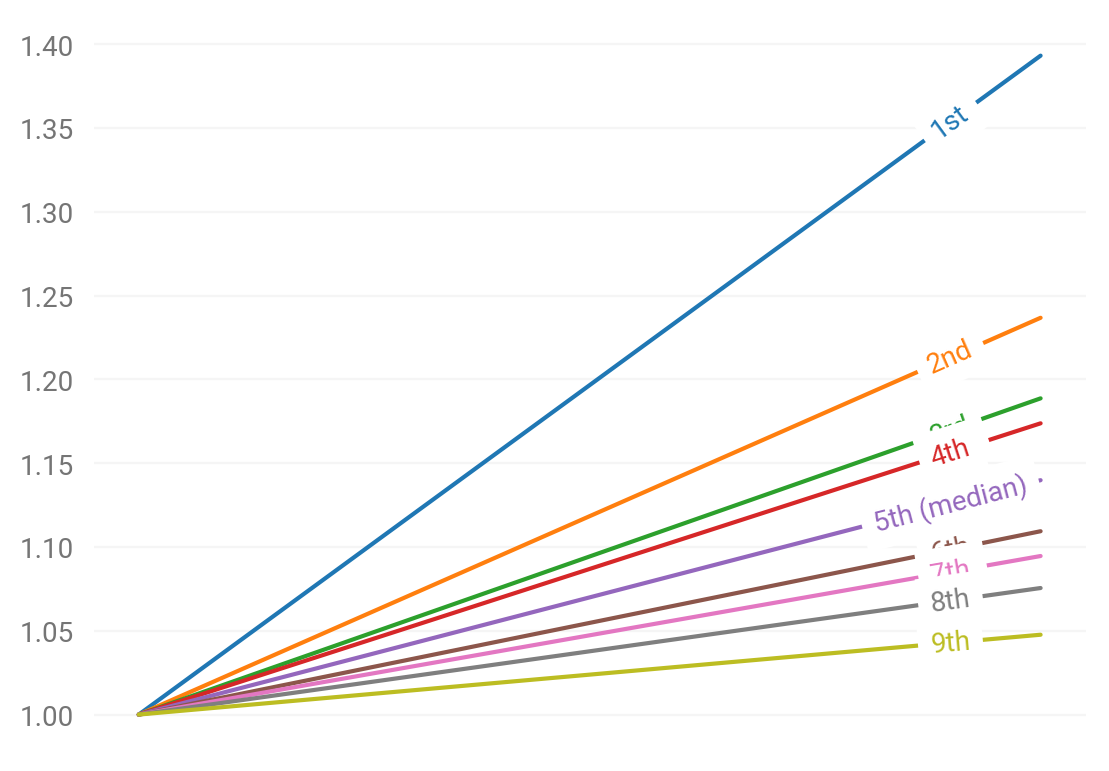

In [63]:
ax = qchg[['one', 'indexed']].transpose().plot()
ax.grid(color=GRID_COLOR, axis='y')
sns.despine(left=True, bottom=True)
ax.get_legend().remove()
ll.labelLines(plt.gca().get_lines(), xvals=np.ones(9) - 0.1)
# plt.gcf().set_size_inches(4, 6)
plt.show()

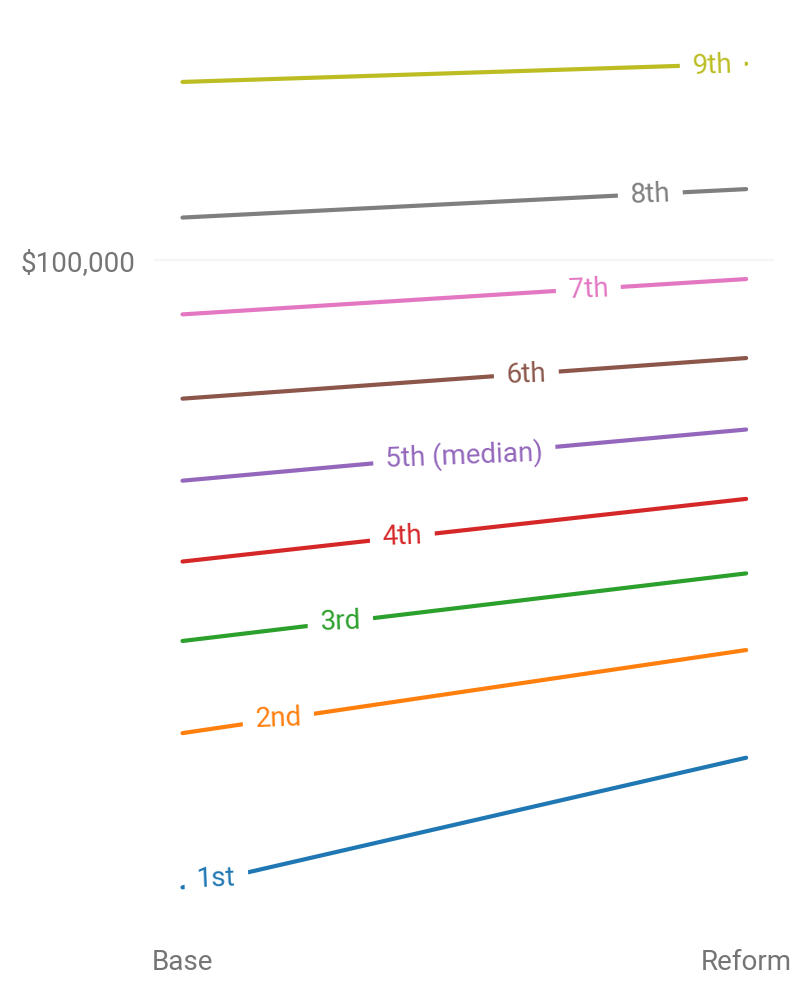

In [64]:
ax = tch.quantile_chg_plot(base.aftertax_income, base.afti_yang, base.s006, base.s006)
ax.grid(color=GRID_COLOR, axis='y')
plt.yscale('log')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda x, _: '$' + format(int(x), ',')))
plt.gcf().set_size_inches(4, 6)
plt.show()

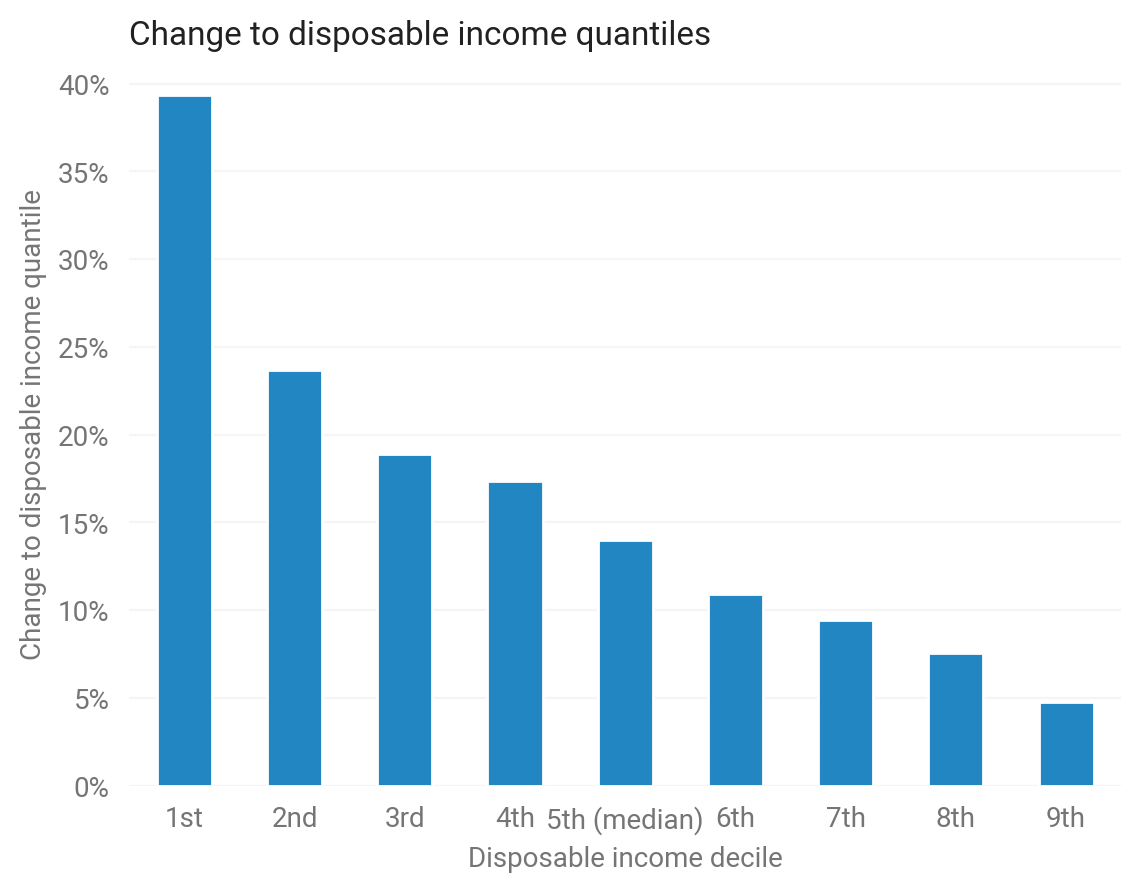

In [65]:
ax = qchg.pct_chg.plot.bar(color='#2286c3')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda x, _: '{:.0%}'.format(x)))
plt.title('Change to disposable income quantiles', loc='left')
ax.grid(color=GRID_COLOR, axis='y')
plt.ylabel('Change to disposable income quantile')
plt.xlabel('Disposable income decile')
sns.despine(left=True, bottom=True)
plt.xticks(rotation=0)
plt.show()

In [66]:
qchg['index_newline'] = np.where(qchg.index == '5th (median)', '5th\n(median)', qchg.index)

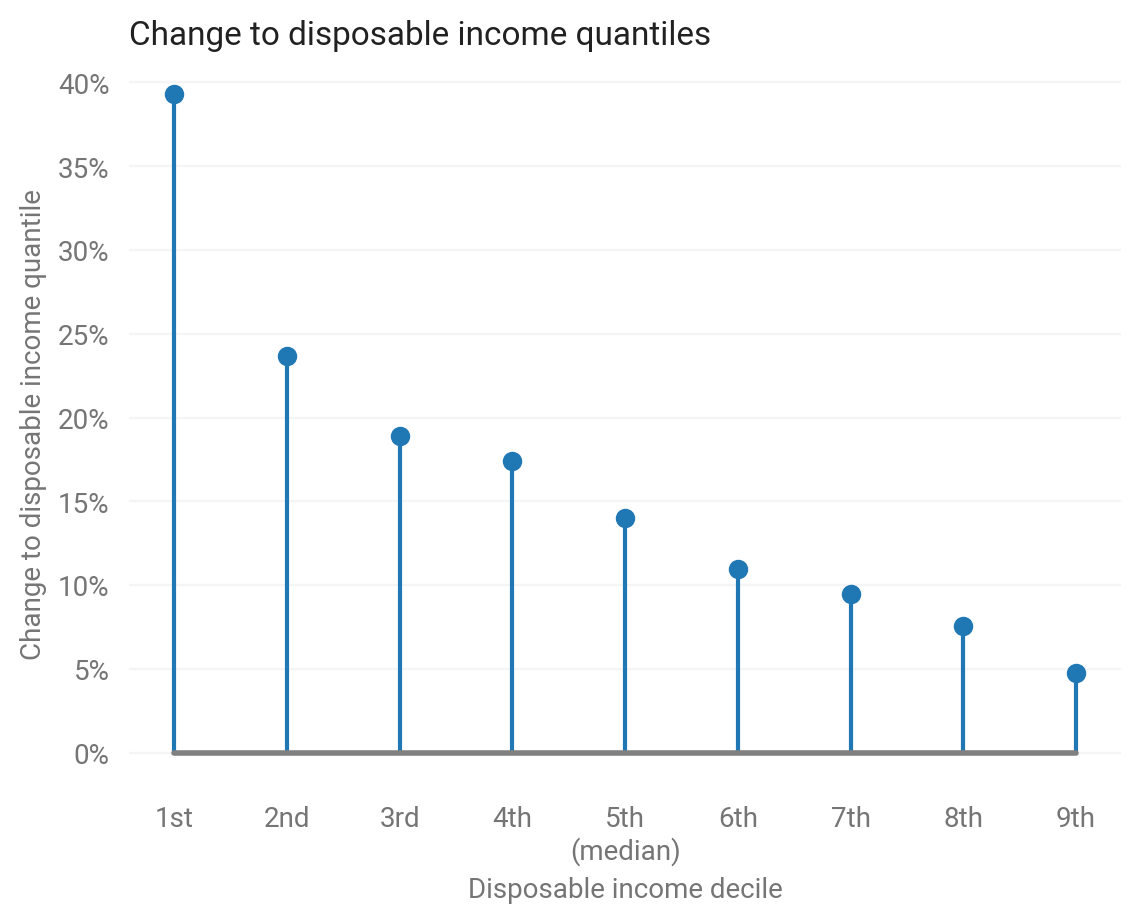

In [67]:
fig, ax = plt.subplots()
markerline, stemlines, baseline = ax.stem(qchg.index_newline, qchg.pct_chg)
plt.setp(baseline, color='gray', linewidth=2)
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda x, _: '{:.0%}'.format(x)))
plt.title('Change to disposable income quantiles', loc='left')
ax.grid(color=GRID_COLOR, axis='y')
plt.ylabel('Change to disposable income quantile')
plt.xlabel('Disposable income decile')
sns.despine(left=True, bottom=True)
plt.xticks(rotation=0)
plt.show()

## Appendix

/home/maxghenis/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/home/maxghenis/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/home/maxghenis/miniconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/maxghenis/miniconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/maxghenis/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.ar

[[Text(-2.0, 0, '0.01'),
  Text(0.0, 0, '1'),
  Text(2.0, 0, '100'),
  Text(4.0, 0, '10000'),
  Text(6.0, 0, '1000000'),
  Text(8.0, 0, '100000000'),
  Text(10.0, 0, '10000000000')]]

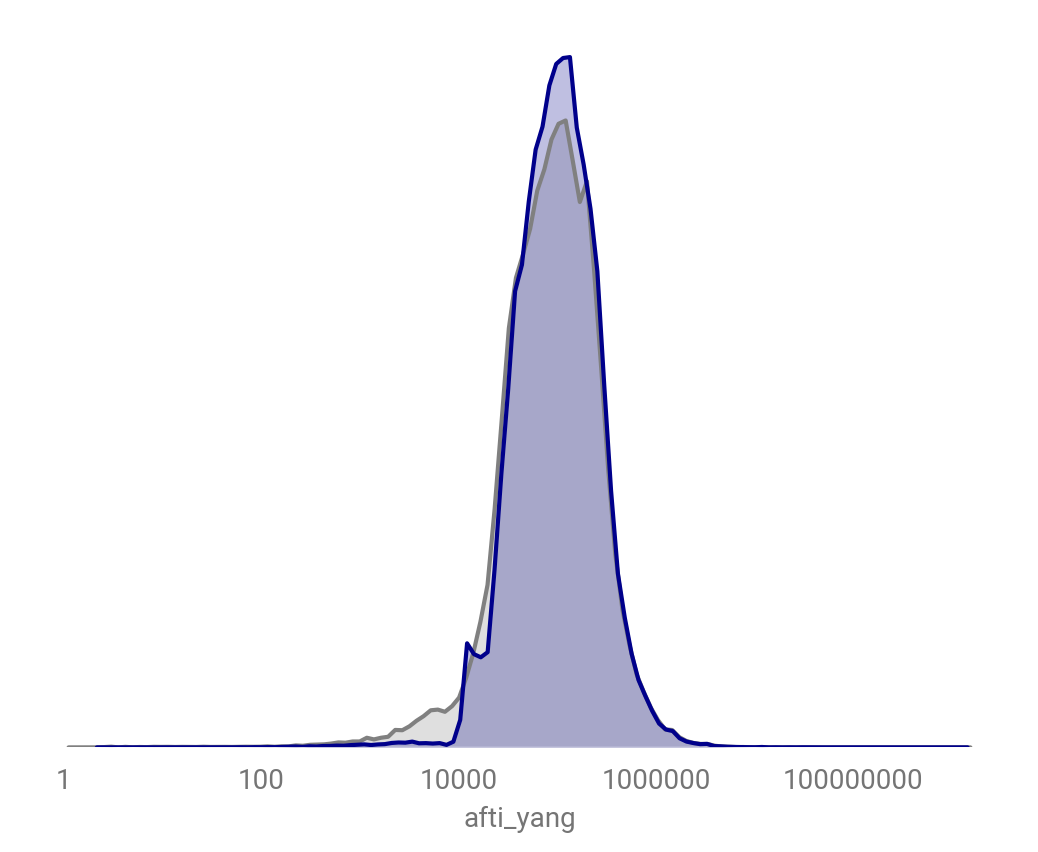

In [68]:
fig, ax = plt.subplots()
sns.distplot(np.log10(base.aftertax_income), color='gray', kde_kws={"shade": True}, hist_kws={'weights': base.s006}, hist=False, ax=ax)
sns.distplot(np.log10(base.afti_yang), color='darkblue', kde_kws={"shade": True}, hist_kws={'weights': base.s006}, hist=False, ax=ax)
plt.setp(ax, yticks=[])
sns.despine(left=True, bottom=True)
fig.canvas.draw()
locs, labels = plt.xticks()
# print([i.get_text() for i in labels])
# print([10 ** int(i.get_text().replace(u'\u2212', '-')) for i in labels])
ax.set(xticklabels=[10 ** int(i.get_text().replace(u'\u2212', '-')) for i in labels])
# plt.xticks(locs, labels) # ['$10^' + item.get_text() + '$' for item in labels])

/home/maxghenis/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/home/maxghenis/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/home/maxghenis/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/home/maxghenis/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


[[Text(-2.0, 0, '$0.01'),
  Text(0.0, 0, '$1'),
  Text(2.0, 0, '$100'),
  Text(4.0, 0, '$10,000'),
  Text(6.0, 0, '$1,000,000'),
  Text(8.0, 0, '$100,000,000'),
  Text(10.0, 0, '$10,000,000,000')]]

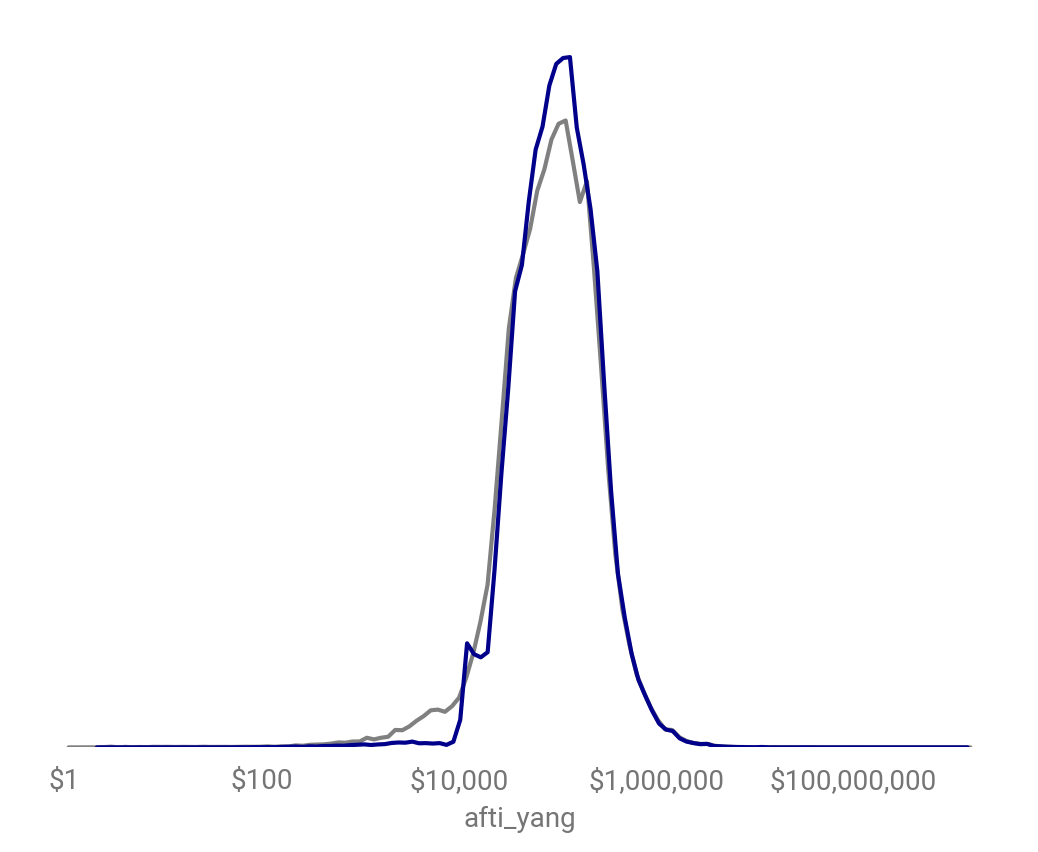

In [69]:
fig, ax = plt.subplots()
sns.distplot(np.log10(base.aftertax_income), color='gray', hist_kws={'weights': base.s006}, hist=False, ax=ax)
sns.distplot(np.log10(base.afti_yang), color='darkblue', hist_kws={'weights': base.s006}, hist=False, ax=ax)
plt.setp(ax, yticks=[])
sns.despine(left=True, bottom=True)
fig.canvas.draw()
locs, labels = plt.xticks()
# print([i.get_text() for i in labels])
# print([10 ** int(i.get_text().replace(u'\u2212', '-')) for i in labels])
# ax.set(xticklabels=['a' for i in labels])
ax.set(xticklabels=['$' + format(10 ** int(i.get_text().replace(u'\u2212', '-')), ',')
                    for i in labels])
# plt.xticks(locs, labels) # ['$10^' + item.get_text() + '$' for item in labels])

/home/maxghenis/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/home/maxghenis/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/home/maxghenis/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/home/maxghenis/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


[[Text(-2.0, 0, '$10^−2$'),
  Text(0.0, 0, '$10^0$'),
  Text(2.0, 0, '$10^2$'),
  Text(4.0, 0, '$10^4$'),
  Text(6.0, 0, '$10^6$'),
  Text(8.0, 0, '$10^8$'),
  Text(10.0, 0, '$10^10$')]]

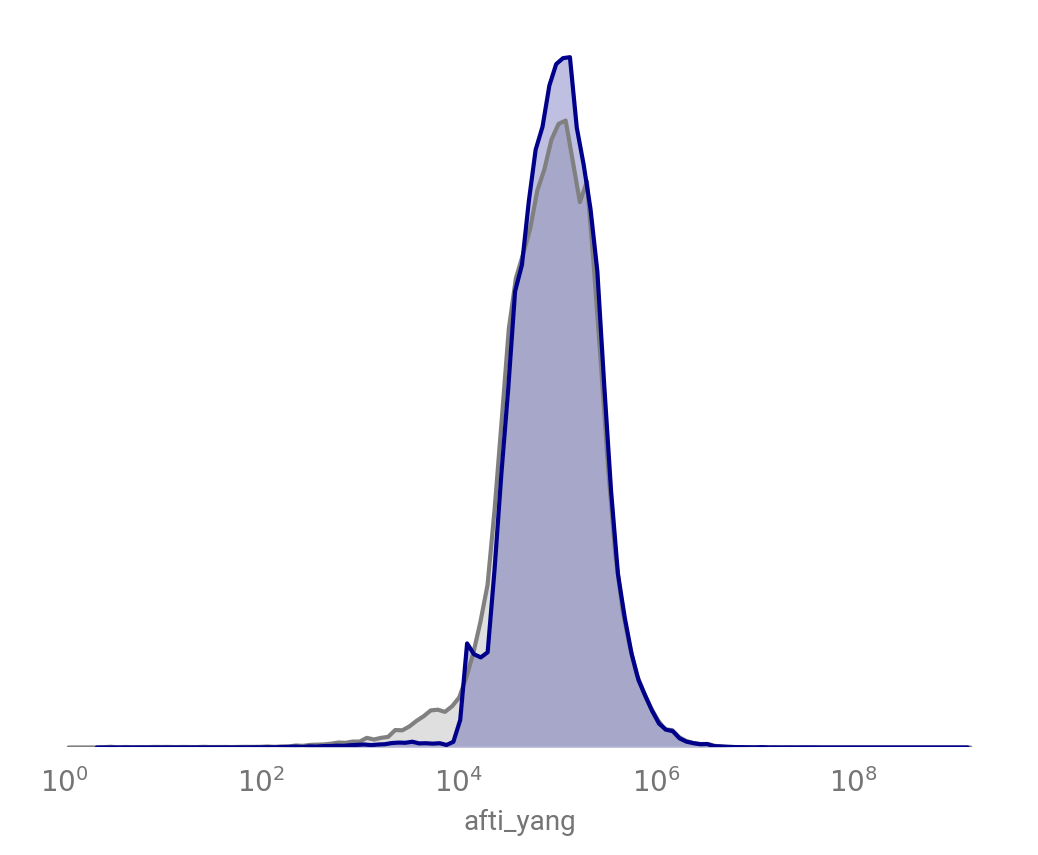

In [70]:
fig, ax = plt.subplots()
sns.distplot(np.log10(base.aftertax_income), color='gray', kde_kws={"shade": True}, hist_kws={'weights': base.s006}, hist=False, ax=ax)
sns.distplot(np.log10(base.afti_yang), color='darkblue', kde_kws={"shade": True}, hist_kws={'weights': base.s006}, hist=False, ax=ax)
plt.setp(ax, yticks=[])
sns.despine(left=True, bottom=True)
fig.canvas.draw()
locs, labels = plt.xticks()
# print([i.get_text() for i in labels])
# print([10 ** int(i.get_text().replace(u'\u2212', '-')) for i in labels])
ax.set(xticklabels=["$10^" + i.get_text() + "$" for i in labels])
# plt.xticks(locs, labels) # ['$10^' + item.get_text() + '$' for item in labels])